In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [3]:
cnbc_news_df = pd.read_csv("./analysis result data/cnbc_news_sentiment_data.csv")
reuters_news_df = pd.read_csv("./analysis result data/reuters_news_sentiment_data.csv")
guardian_news_df = pd.read_csv("./analysis result data/guardian_news_sentiment_data.csv")

news_df = pd.DataFrame()
news_df["Date"] = cnbc_news_df["Date"]
news_df["cnbc"] = cnbc_news_df["Sentiment"]
news_df["reuters"] = reuters_news_df["Sentiment"]
news_df["guardian"] = guardian_news_df["Sentiment"]
news_df["Sentiment"] = news_df.mean(axis=1)
news_df.drop(columns=["cnbc", "reuters", "guardian"])

C:\Users\baruchfrost\AppData\Local\Temp\ipykernel_24236\3513426556.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  news_df["Sentiment"] = news_df.mean(axis=1)


,Date,Sentiment
0,2019-07-01,0.047269
1,2019-07-02,0.035393
2,2019-07-08,0.049285
3,2019-07-09,0.051902
4,2019-07-10,0.052582
...,...,...
251,2020-06-25,-0.021083
252,2020-06-26,0.088692
253,2020-06-29,0.019711
254,2020-06-30,0.038572


In [4]:
dji_df = pd.read_csv("./daily data/DOW.csv")

dji_df['Date (Datetime)'] = pd.to_datetime(dji_df['Date'])

start_date = pd.Timestamp('2019-07-01')
end_date = pd.Timestamp('2020-07-01')
dji_df = dji_df[(dji_df['Date (Datetime)'] >= start_date) & (dji_df['Date (Datetime)'] < end_date)]

dji_df.drop(columns=["Date (Datetime)"], inplace=True)

In [5]:
dji_df["Sentiment"] = news_df["Sentiment"]
dji_df["Change"] = dji_df["Close"] - dji_df["Open"]

In [6]:
dji_df.set_index("Date", inplace=True)

In [7]:
chunkized = np.array_split(dji_df, 8)

best_shifts = []
best_spans = []
best_correlations = []
best_mean_correlation = 0

In [8]:
for i in tqdm.tqdm(range(1, 13)):
    chunkized = np.array_split(dji_df, i)
    best_shifts_in_chunk = [0] * i
    best_spans_in_chunk = [0] * i
    best_correlations_in_chunk = [0] * i

    for i, chunk in enumerate(chunkized):
        for span in range(0, 91):
            for shift in range(0, 11):
                chunk["Transformed Sentiment"] = chunk["Sentiment"].shift(shift)
                if span != 0:
                    chunk["Transformed Sentiment"] = chunk["Transformed Sentiment"].ewm(span=span).mean()
                corr = chunk["Transformed Sentiment"].corr(chunk["Change"], method="spearman")
                if corr > best_correlations_in_chunk[i]:
                    best_correlations_in_chunk[i] = corr
                    best_shifts_in_chunk[i] = shift
                    best_spans_in_chunk[i] = span

    if np.min(best_correlations_in_chunk) > best_mean_correlation:
        best_shifts = best_shifts_in_chunk
        best_spans = best_spans_in_chunk
        best_correlations = best_correlations_in_chunk


  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:48<00:00,  4.06s/it]


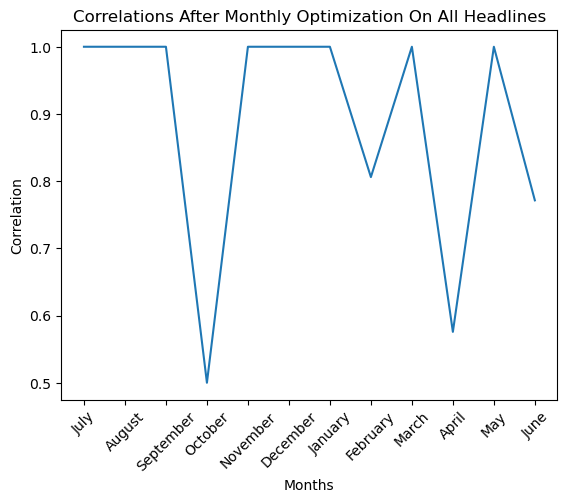

Optimal Correlations
[0.9999999999999999, 0.9999999999999999, 1.0, 0.5, 1.0, 0.9999999999999999, 0.9999999999999999, 0.8060606060606059, 1.0, 0.5757575757575757, 0.9999999999999999, 0.7714285714285715]
-----------------------------------------------------------
Optimal Shifts (how many days back are we looking?)
[9, 9, 8, 8, 8, 8, 8, 0, 7, 0, 8, 4]
------------------------------------------------------------
Optimal EMA Spans
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]


In [12]:
plt.plot(best_correlations_in_chunk)
plt.xticks(range(0, 12), ['July', 'August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May', 'June'], rotation=45)
plt.ylabel("Correlation")
plt.xlabel("Months")
plt.title("Correlations After Monthly Optimization On All Headlines")
plt.show()
print("Optimal Correlations")
print(best_correlations_in_chunk)
print("-----------------------------------------------------------")
print("Optimal Shifts (how many days back are we looking?)")
print(best_shifts_in_chunk)
print("------------------------------------------------------------")
print("Optimal EMA Spans")
print(best_spans_in_chunk)